In [1]:
import tensorflow as tf
from nn_class import DenseNetwork, DeepONet
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas as pd

2025-10-15 16:47:41.342654: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# DeepONet architecture
We would like to approximate the normal derivative of the potential of the electric field with a DeepONet architecture. \
The branch net has 3 input parameter, the geometric parameters: overetch, distance, angle, which define the mesh;\
The trunk net has 1 input parameter, the curvilnear absissa, and 1 output, the value of the electric field.

In [173]:
# Reproducibility setup --------------------------------------------------------
np.random.seed(1)
tf.random.set_seed(1)
tf.keras.utils.set_random_seed(1)

# Hyperparameters setup --------------------------------------------------------
r = 20     # low-rank dimension
p = 3      # number of problem parameters = geometrical parameters
d = 1      # number of spatial dimensions
ns = 1000  # number of samples = number of meshes
nh = 350   # number of dofs = x-coordinates available for each mesh

# Training setup ---------------------------------------------------------------
epochs = 1000
batch_size = 3

# Data --------------------------------------------------------------
data_csv = pd.read_csv('../data/unrolled_normal_derivative_potential.csv')
mu_data = data_csv.iloc[:, 1:4] # geometrical parameters
mu_data = np.array(mu_data)
#Now we have to reshape mu_data to be ns x p (remove duplicates)
mu_data = mu_data[::nh, :]
x_data = data_csv.iloc[:, 4]    # x-coordinates
x_data = np.array(x_data)
#Now we have to reshape x_data to be ns x nh x d
x_data = x_data.reshape((ns, nh, d))
u_data = data_csv.iloc[:, 5]    # solution at x-coordinates
u_data = np.array(u_data)
#Now we have to reshape u_data to be ns x nh
u_data = u_data.reshape((ns, nh))
print(mu_data.shape) # should be ns x p
print(x_data.shape) # should be ns x nh x d
print(u_data.shape) # should be ns x nh

(1000, 3)
(1000, 350, 1)
(1000, 350)


In [174]:
# Network construction
branch = DenseNetwork(
    width = 20,
    depth = 3,
    output_dim = r, 
    input_dim = p, 
    activation = 'relu'
    )
trunk = DenseNetwork(
    width = 20,
    depth = 4,
    output_dim = r,
    input_dim = d,
    activation = 'relu'
)
deeponet = DeepONet(branch, trunk)

# Checking implementation correctness (should be ns x nh)
print(deeponet((mu_data, x_data)).shape)    # if the samples have different spatial points in which they are evaluated
print(deeponet((mu_data, x_data[0])).shape) # if the samples have the same spatial points

(1000, 350)
(1000, 350)


In [175]:
# Data splitting
ns_train = ns // 2
ns_test = ns // 4
mu_train, mu_val, mu_test = mu_data[:ns_train], mu_data[ns_train:-ns_test], mu_data[-ns_test:]
x_train, x_val, x_test = x_data[:ns_train], x_data[ns_train:-ns_test], x_data[-ns_test:]
u_train, u_val, u_test = u_data[:ns_train], u_data[ns_train:-ns_test], u_data[-ns_test:]

In [176]:
# Training
deeponet.compile(optimizer = 'adam', loss = 'mse')
deeponet.fit(
    x = [mu_train, x_train],
    y = u_train,
    validation_data = ([mu_val, x_val], u_val),
    epochs = epochs,
    batch_size = batch_size
)

Epoch 1/1000
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5933.6055 - val_loss: 342.5190
Epoch 2/1000
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 71.6670 - val_loss: 158.3575
Epoch 3/1000
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.8038 - val_loss: 91.2295
Epoch 4/1000
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.1529 - val_loss: 46.8414
Epoch 5/1000
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.6695 - val_loss: 25.6599
Epoch 6/1000
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7220 - val_loss: 14.3953
Epoch 7/1000
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6186 - val_loss: 9.6920
Epoch 8/1000
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3504 - val_loss: 7.3432
Epoch 9/1000
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2832 - val_loss: 6.4431
Epoch 10/1000
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6761 - val_loss: 5.6232
Epoch 11/1000
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5481 - val_loss: 5.1305
Epoch 12/1000
16

In [ ]:
# To save model
#deeponet.save("../models/deeponet_model_relu.keras")

# To load existing model
import keras

loaded_mod = keras.models.load_model(
    "../models/deeponet_model_gelu.keras",
    custom_objects={"DeepONet": DeepONet, "DenseNetwork": DenseNetwork}
)


TypeError: <class 'nn_class.DeepONet'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'nn_class', 'class_name': 'DeepONet', 'config': {'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}}, 'registered_name': 'DeepONet', 'build_config': {'input_shape': [[1000, 3], [1000, 350, 1]]}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'adam', 'learning_rate': 0.0010000000474974513, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': 'mse', 'loss_weights': None, 'metrics': None, 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': False}}.

Exception encountered: Unable to revive model from config. When overriding the `get_config()` method, make sure that the returned config contains all items used as arguments in the  constructor to <class 'nn_class.DeepONet'>, which is the default behavior. You can override this default behavior by defining a `from_config(cls, config)` class method to specify how to create an instance of DeepONet from its config.

Received config={'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}}

Error encountered during deserialization: DeepONet.__init__() got an unexpected keyword argument 'trainable'

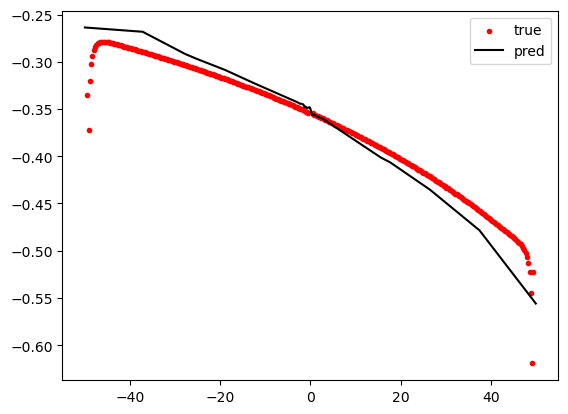

In [180]:
# Visualizing a test sample and its approximation using deeponets
#Set seed for reproducibility
np.random.seed(99)
# index of the test sample (= combination of geometric parameters) to plot
idx_plot = np.random.randint(0, mu_test.shape[0]) 
# number of points in which to evaluate the solution
points = 1000 
x_lin = np.linspace(-50, 50, points)[:,None]
u_pred_test = deeponet([mu_test, x_lin])
plt.figure()
plt.scatter(x_test[idx_plot], u_test[idx_plot], marker = '.', color = 'r', label = 'true')
plt.plot(x_lin, u_pred_test[idx_plot], 'k-', label = 'pred')
plt.legend();  # Added semicolon to suppress memory location output

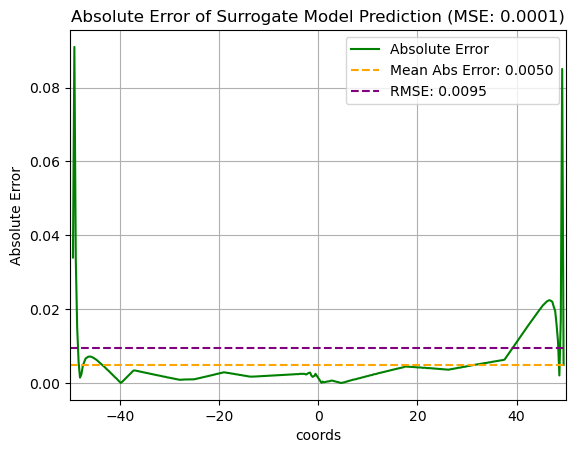

In [179]:
# Error visualization
# Plot the absolute difference between prediction and true values
coords = x_test[idx_plot] 
u = u_test[idx_plot]
u_pred = (deeponet([mu_test, coords]))[idx_plot]
abs_diff = np.abs(u - u_pred)
mse = np.mean((u - u_pred) ** 2)
plt.figure(2)
coords = coords.reshape(-1) #remove second dimension
plt.plot(coords, abs_diff, label="Absolute Error", color="green")
plt.xlim(-50, 50)
plt.xlabel("coords")
plt.ylabel("Absolute Error")
plt.title(f"Absolute Error of Surrogate Model Prediction (MSE: {mse:.4f})")
mean_abs_error = np.mean(abs_diff)
plt.axhline(mean_abs_error, color="orange", linestyle="--", label=f"Mean Abs Error: {mean_abs_error:.4f}")
plt.axhline(np.sqrt(mse), color="purple", linestyle="--", label=f"RMSE: {np.sqrt(mse):.4f}")
plt.legend()
plt.grid(True)
plt.show()